In [268]:
import math as ma
import yfinance as yf
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt 
import pandas_ta as ta
import tensorflow as tf

from keras import optimizers
from keras.callbacks import History

np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


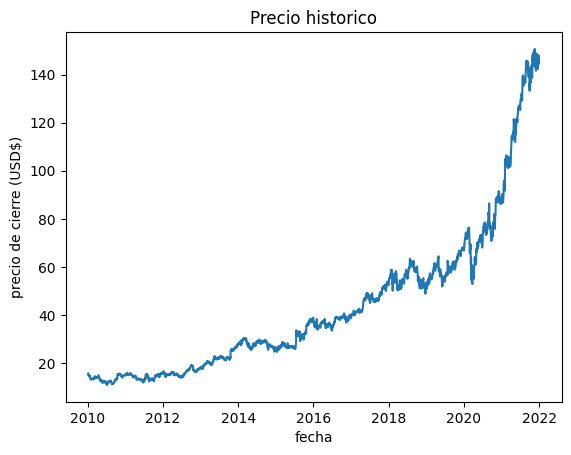

(330, 5)


In [269]:
#var de testeo
stride = 30
simbolo = "Goog"
#conseguir la data
#dfTrain = web.DataReader('SYP', 'stooq', dt.datetime(2020,1,1), dt.datetime(2023,1,1))
dfTrain = yf.download(tickers= simbolo, start= dt.datetime(2010,1,1), end= dt.datetime(2022,1,1))
dfTest =  yf.download(simbolo, start = dt.datetime(2022,1,1),end = dt.date.today()) #dt.date.today())

dataTrain = dfTrain.filter(['Close'])
grafData = dataTrain.copy()
#agrego indicadores: 
dataTrain['RSI']=ta.rsi(dataTrain['Close'], length=15)
dataTrain['EMAF']=ta.ema(dataTrain['Close'], length=20)
dataTrain['EMAM']=ta.ema(dataTrain['Close'], length=100)
dataTrain['EMAS']=ta.ema(dataTrain['Close'], length=150)
dataTrain.dropna(inplace=True)
#dataTrain.reset_index(inplace = True)
#agrego indicadores para test: 
dataTest = dfTest.filter(['Close'])

dataTest['RSI']=ta.rsi(dataTest['Close'], length=15)
dataTest['EMAF']=ta.ema(dataTest['Close'], length=20)
dataTest['EMAM']=ta.ema(dataTest['Close'], length=100)
dataTest['EMAS']=ta.ema(dataTest['Close'], length=150)

dataTestAux = dataTest['Close'][:149]
dataTest.dropna(inplace=True)




plt.title('Precio historico')
plt.plot(grafData)
plt.xlabel("fecha")
plt.ylabel("precio de cierre (USD$)")
# plt.axis((2020,2023,ma.floor(min(dataTrain.values)), ma.ceil(max(dataTrain.values))))
plt.show()


# print((dataTrain['Close'][0] - min(dataTrain['Close']))/(max(dataTrain['Close'])-min(dataTrain['Close'])))
# print(dataTrain)

dataTrain =dataTrain.values 
dataTest = dataTest.values


# dataTrain = np.flip(dataTrain)
# dataTest = np.flip(dataTest)

print((dataTest.shape))


In [270]:
#normalizar la data 
scaler = MinMaxScaler(feature_range=(0,1))
dataNormTrain = scaler.fit_transform(dataTrain)
dataNormTest = scaler.fit_transform(dataTest)
print(dfTest['Close'][-10:])

# print(dataNormTrain[0:stride+1,:])
# print(dataNormTrain[stride,:])
# print(dataNormTrain)
print(dataTest[-10:,0])
print(dataNormTest[-10:,0])

# print(dataNormTest[0:stride+1,:])
# print(dataNormTest[stride,:])

Date
2023-11-14    135.429993
2023-11-15    136.380005
2023-11-16    138.699997
2023-11-17    136.940002
2023-11-20    137.919998
2023-11-21    138.619995
2023-11-22    140.020004
2023-11-24    138.220001
2023-11-27    138.050003
2023-11-28    138.619995
Name: Close, dtype: float64
[135.4299927 136.3800049 138.6999969 136.9400024 137.9199982 138.6199951
 140.0200043 138.2200012 138.0500031 138.6199951]
[0.8922865 0.9086069 0.9484625 0.9182272 0.9350627 0.9470881 0.9711391
 0.9402165 0.9372961 0.9470881]


In [271]:
#crear el dataset de entrenamiento 
#separar entre X e Y dataSets
#X son las entradas e Y es la salida esperada
x_train = []
y_train = []


for i in range(stride, len(dataNormTrain)):
    x_train.append(dataNormTrain[i-stride:i, :])
    y_train.append(dataNormTrain[i,0])
    # if i<=stride:
    #     print(x_train)
    #     print(y_train)

#print(x_train[3], y_train[:3])

# for i in range(len(x_train)):
#     print(x_train[i], y_train[i]) 

#yi = np.array(dataNormTrain[stride:,-1])
#y=np.reshape(yi,(len(yi),1))

# for i in range(stride,len(dataNormTrain)):
#     x_train.append(dataNormTrain[i-stride:i,0])
#     y_train.append(dataNormTrain[i,0])




In [272]:
#hacerlos np.arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
#el modelo necesita el numero de samples, de datos y de features

In [273]:
#construir la red LSTM 

lstm_input = Input(shape=(stride, x_train.shape[2]), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
#inputs = LSTM(100, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)    
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=x_train, y=y_train, epochs=50, batch_size=15, shuffle=True, validation_split = 0.1) 

Epoch 1/50
171/171 [==============================] - 5s 17ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 2/50
171/171 [==============================] - 3s 16ms/step - loss: 8.6544e-05 - val_loss: 0.0011
Epoch 3/50
171/171 [==============================] - 3s 17ms/step - loss: 6.7666e-05 - val_loss: 7.8900e-04
Epoch 4/50
171/171 [==============================] - 3s 17ms/step - loss: 6.1813e-05 - val_loss: 3.6441e-04
Epoch 5/50
171/171 [==============================] - 3s 15ms/step - loss: 6.6914e-05 - val_loss: 3.6296e-04
Epoch 6/50
171/171 [==============================] - 3s 15ms/step - loss: 6.3638e-05 - val_loss: 5.9432e-04
Epoch 7/50
171/171 [==============================] - 2s 14ms/step - loss: 6.0206e-05 - val_loss: 5.1453e-04
Epoch 8/50
171/171 [==============================] - 3s 17ms/step - loss: 5.9122e-05 - val_loss: 2.6857e-04
Epoch 9/50
171/171 [==============================] - 3s 18ms/step - loss: 5.9720e-05 - val_loss: 3.7413e-04
Epoch 10/50
171/171 [==========

In [ ]:
#crea datos para test
#separa en X y en Y 

testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
#!no esta bien pq se saltea los que borre de test
#print(testData)
x_test = []
y_test = dataTest[:,0]

# print(len(dataTest))

for i in range(stride, len(testData)):
     x_test.append(testData[i-stride:i,:])
#X contiene los valores no contempleados en el train, e y contiene la salida esperada
x_test = np.array(x_test)

#x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],x_test.shape[2]))
#print(x_test[1])
#print(y_test[1])


In [ ]:
#print(model.predict(x_test[:-30]))

In [ ]:
#prediccion del modelo para test
prediccion = np.zeros((x_test.shape[0],5))
aux = model.predict(x_test)
aux = np.reshape(aux,(aux.shape[0]))
#print(aux)
prediccion[:,0] = aux[:]
prediccion = scaler.inverse_transform(prediccion)
prediccion = prediccion[:,0]
# print(prediccion.shape[0])

11/11 [==============================] - 1s 11ms/step


In [ ]:
# print(prediccion[:10])
# print(y_test[:10])

In [ ]:
#calcular error del modelo (RMSE)
print(len(prediccion))
rmse = np.sqrt(np.mean((prediccion - y_test)**2))
print("{:.2f}".format(rmse))


330
4.25


In [ ]:
# prediccion = np.flip(prediccion)

In [ ]:
#Arma las estructuras para  graficar
train = dfTrain
valid = dfTest
prediccion = np.concatenate((dataTestAux[:], prediccion[:]))

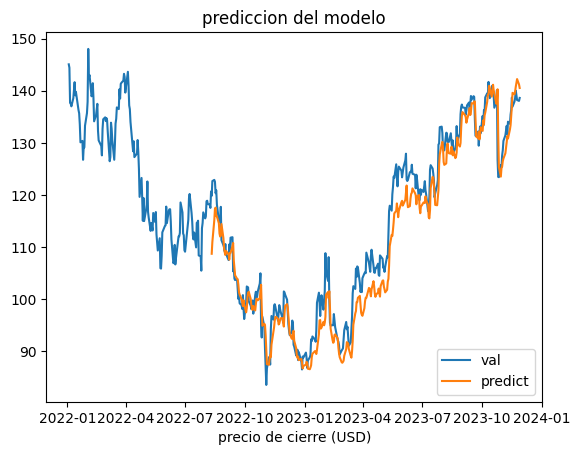

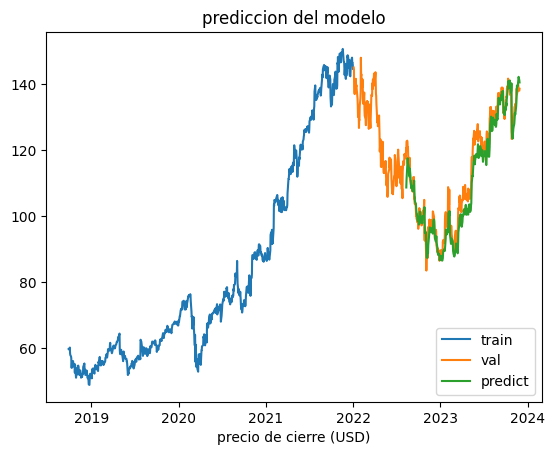

In [ ]:

#testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
valid['Predictions'] = prediccion

#plot
plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
#plt.plot(train['Close'][2000:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['val', 'predict'], loc = 'lower right')
plt.figure()


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
plt.plot(train['Close'][2200:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['train', 'val', 'predict'], loc = 'lower right')
plt.show()


In [ ]:
valid = valid[153:]

326


C:\Users\nahue\AppData\Local\Temp\ipykernel_8332\692747874.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difPred = [valid['Predictions'][i+1] - valid['Predictions'][i] for i in range(valid.shape[0]-1)]
C:\Users\nahue\AppData\Local\Temp\ipykernel_8332\692747874.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  difVal = [valid['Close'][i+1] - valid['Close'][i] for i in range(valid.shape[0]-1)]


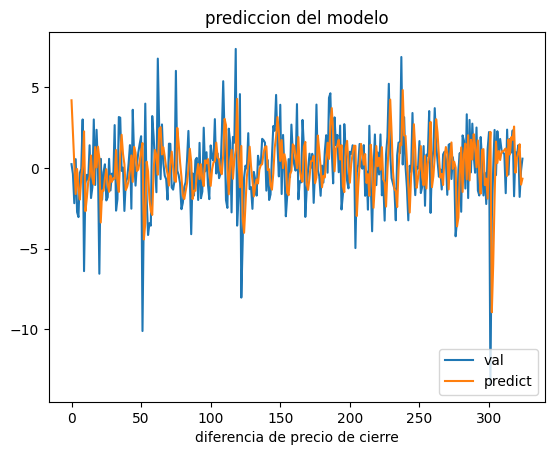

In [ ]:
print(valid.shape[0])
difPred = [valid['Predictions'][i+1] - valid['Predictions'][i] for i in range(valid.shape[0]-1)]
difVal = [valid['Close'][i+1] - valid['Close'][i] for i in range(valid.shape[0]-1)]
difPred = np.array(difPred)
difVal = np.array(difVal)


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("diferencia de precio de cierre")
plt.plot(difVal)
plt.plot(difPred) 
plt.legend(['val', 'predict'], loc = 'lower right')
plt.show()

In [ ]:
combined_arrays = zip(difVal, difPred)
same_sign_count = sum(1 for a, b in combined_arrays if (a > 0 and b > 0) or (a < 0 and b < 0))
print((same_sign_count / difVal.shape[0])*100)

48.92307692307693


In [ ]:
#imprimir los valores
print(valid[['Close', 'Predictions']][149:])

                 Close  Predictions
Date                               
2023-03-17  102.459999    95.054909
2023-03-20  101.930000    97.251972
2023-03-21  105.839996    97.680753
2023-03-22  104.220001    99.404043
2023-03-23  106.260002    99.384973
...                ...          ...
2023-11-21  138.619995   139.867875
2023-11-22  140.020004   140.782722
2023-11-24  138.220001   142.245992
2023-11-27  138.050003   141.207458
2023-11-28  138.619995   140.535697

[177 rows x 2 columns]


In [ ]:
#simulacion de trading 

#print(dataNormTest[:,0])
dataReal = valid['Predictions']
dataReal = np.array(dataReal)

dataTestSemana = dataReal[-5:]
dataTestMes = dataReal[-20:]
dataTestAnual = dataReal[-250:]

testCase = dataTestAnual
#print(len(dataTestSemana))
# print(dataTestMes)
# print(dataTestAnual)

#difPred
difPredS = difPred[-len(testCase):]
dineroHist = []

#simulacion:
dineroInicial = 400

cantAcciones =ma.floor(dineroInicial/testCase[0])
dinero = dineroInicial - cantAcciones*testCase[0]
print(dinero)
for i in range(len(testCase)):
    print()
    print('precio diario: ',testCase[i])
    print('diferencia: ', difPredS[i])
    
    if (difPredS[i] > 0): #si mañana va a subir, compro y holdeo
        while (dinero >= testCase[i]):
            cantAcciones += 1
            dinero -= testCase[i]
    else: #va a bajar, conviene vender
        dinero += cantAcciones*testCase[i]
        cantAcciones = 0
    print('dinero:', dinero)
    print('cant acciones:', cantAcciones)
    dineroHist.append(dinero + cantAcciones*testCase[i])

dinero += cantAcciones*testCase[i]
cantAcciones = 0

print()
print('Dinero inicial: $',dineroInicial)
print('Dinero final: $', dinero)
print('Rendimiento: ',(1- dineroInicial / dinero)*100 ,'%')
# print(testCase)
# print(predic)


21.198571883583554

precio diario:  94.70035702910411
diferencia:  -0.8668119541569013
dinero: 400.0
cant acciones: 0

precio diario:  97.17636658704566
diferencia:  2.476009557941552
dinero: 11.294533651817346
cant acciones: 4

precio diario:  98.67298218659357
diferencia:  1.4966155995479085
dinero: 11.294533651817346
cant acciones: 4

precio diario:  99.01738199846477
diferencia:  0.34439981187119884
dinero: 11.294533651817346
cant acciones: 4

precio diario:  98.43533287175546
diferencia:  -0.5820491267093075
dinero: 405.0358651388392
cant acciones: 0

precio diario:  96.71832914930053
diferencia:  -1.7170037224549333
dinero: 405.0358651388392
cant acciones: 0

precio diario:  94.78822777218886
diferencia:  -1.9301013771116686
dinero: 405.0358651388392
cant acciones: 0

precio diario:  93.36206732720348
diferencia:  -1.4261604449853849
dinero: 405.0358651388392
cant acciones: 0

precio diario:  92.41675077822674
diferencia:  -0.9453165489767343
dinero: 405.0358651388392
cant accion

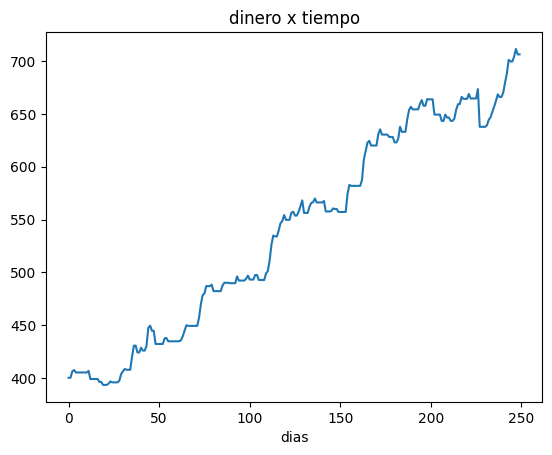

In [ ]:
#print(dineroHist)

plt.title("dinero x tiempo")
plt.xlabel("dinero")
plt.xlabel("dias")
plt.plot(dineroHist) 
plt.show()

